In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./df_guardado_clean.csv')

In [3]:
df.head()

,order_id,Fecha,Hora,avg_actual_delivery_time_minutes,avg_promised_delivery_time_minutes,to_pickup,to_dropoff,Vendor_id,llueve,ph
0,131748347,Viernes,13,69.100000,31.900000,1.348,0.489,1,1,0
1,131749603,Viernes,13,36.700000,30.883333,0.359,0.513,1,1,0
2,131748367,Viernes,13,32.833333,32.666667,0.735,0.684,1,1,0
3,131743177,Viernes,12,39.383333,40.600000,0.166,2.121,1,1,0
4,131738512,Viernes,11,29.450000,35.883333,2.924,2.898,1,1,0


# Benchmark: Error que trae el modelo actual

In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [5]:
Z = df
RMSE_py = np.sqrt(mean_squared_error(Z['avg_actual_delivery_time_minutes'], Z['avg_promised_delivery_time_minutes'])).round(2)
MAE_py = mean_absolute_error(Z['avg_actual_delivery_time_minutes'], Z['avg_promised_delivery_time_minutes']).round(2)
RMSE_py, MAE_py

(12.04, 8.2)

In [6]:
X = df[df['Vendor_id']<12].drop(['avg_actual_delivery_time_minutes'
                                 ,'avg_promised_delivery_time_minutes'
                                ], axis=1)
X = pd.get_dummies(X, columns=['Vendor_id', 'Fecha'])

In [7]:
y = df[df['Vendor_id']<12]['avg_actual_delivery_time_minutes']

In [8]:
X.columns

Index(['order_id', 'Hora', 'to_pickup', 'to_dropoff', 'llueve', 'ph',
       'Vendor_id_1', 'Vendor_id_2', 'Vendor_id_3', 'Vendor_id_4',
       'Vendor_id_5', 'Vendor_id_6', 'Vendor_id_7', 'Vendor_id_8',
       'Vendor_id_9', 'Vendor_id_10', 'Vendor_id_11', 'Fecha_Domingo',
       'Fecha_Jueves', 'Fecha_Lunes', 'Fecha_Martes', 'Fecha_Miercoles',
       'Fecha_Sabado', 'Fecha_Viernes'],
      dtype='object')

# 0) Imports, custom func & split

In [9]:
#sklearn important imports

#Models
#1
from sklearn.ensemble import RandomForestRegressor
#2
from sklearn.tree import DecisionTreeRegressor
#3
from sklearn.ensemble import AdaBoostRegressor
#4
from sklearn.ensemble import GradientBoostingRegressor
#5
from sklearn.svm import SVR
#6
#ANN in an other notebook for compitibilty

#Support
#Train test holdout split
from sklearn.model_selection import train_test_split
# Error metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [10]:
def split_Xy(X_,y_, hold_out_size=1/10, test_size=2/9, random_state=42):
    
    """
    Funcion split_Xy:
            devuelve los splits como tuplas globales
            permite elegir los ratios de split y el random state

    * Debes importar lo siguente:
    from sklearn.model_selection import train_test_split
    """    
    
    #make variable global
    global X, X_holdout, X_train, X_test, y, y_holdout, y_train, y_test
    
    
    #create tuples
    (X), (X_holdout), (y), (y_holdout) = train_test_split(X_, y_, test_size=hold_out_size, random_state=random_state)
    (X_train), (X_test), (y_train), (y_test) = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print('Successful split')

In [11]:
def tune(model, X=X, y=y):
    
    """
    Funcion tune:
                    hace fit con X, y con cv por como esta hecho el modelo, no por esta funcion
                    encuentra los mejores hiperparametros
                    hace fit con X, y y los mejores hiperparametros que encontro
                    predice con X_holdout
                    compara con y_holdout
                    devuelve un dataframe con la metadata

    * Debes importar lo siguente:
    
    VERIFICAR LAS IMPORTACIONES
    
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    """
    
    model.fit(X, y)
    y_pred = model.best_estimator_.predict(X_holdout)
    RMSE = np.sqrt(mean_squared_error(y_holdout, y_pred)).round(2)
    MAE = mean_absolute_error(y_holdout, y_pred).round(2)

    print(f'{model}')
    print(f'{model.best_params_}')
    print('MAE, RMSE')
    print(f'{MAE}, {RMSE}')
    return pd.DataFrame(model.cv_results_), MAE, RMSE

In [12]:
def tune_sc(model, X_sc, y=y):
    
    """
    Funcion tune_sc:
                    hace fit con X_sc, y con cv por como esta hecho el modelo, no por esta funcion
                    encuentra los mejores hiperparametros
                    hace fit con X_Sc, y y los mejores hiperparametros que encontro
                    predice con X_sc_holdout
                    compara con y_holdout
                    devuelve un dataframe con la metadata

    * Debes importar lo siguente:
    
    VERIFICAR LAS IMPORTACIONES
    
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    """
    
    model.fit(X_sc, y)
    y_pred = model.best_estimator_.predict(X_sc_holdout)
    RMSE = np.sqrt(mean_squared_error(y_holdout, y_pred)).round(2)
    MAE = mean_absolute_error(y_holdout, y_pred).round(2)

    print(f'{model}')
    print(f'{model.best_params_}')
    print('MAE, RMSE')
    print(f'{MAE}, {RMSE}')
    return pd.DataFrame(model.cv_results_), MAE, RMSE

In [13]:
split_Xy(X,y)

Successful split


# 1) Random Forest Regressor

In [14]:
# import the Model
from sklearn.ensemble import RandomForestRegressor

# Instantiate the empty model
model = RandomForestRegressor()

# import from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

#import scororing function maker and scoring metrics
from sklearn.metrics import make_scorer, mean_absolute_error

# Define params as dictionary
params = {
            'max_depth': [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
            'n_estimators': [100, 150, 200]
            }

# Define scoring func
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Define cv
cv = 3

# Define verbose (0,1,2,3)
verbose = 3


# Instantiate grid  model
grid = GridSearchCV(model, params, scoring=scoring, cv=cv, verbose=verbose) #for example...


# Compute and save
resultados_rf, MAE_rf, RMSE_rf = tune(grid, X, y)




Fitting 3 folds for each of 42 candidates, totalling 126 fits
[CV 1/3] END ...max_depth=2, n_estimators=100;, score=-10.561 total time=   2.2s
[CV 2/3] END ...max_depth=2, n_estimators=100;, score=-10.346 total time=   2.2s
[CV 3/3] END ...max_depth=2, n_estimators=100;, score=-10.541 total time=   2.2s
[CV 1/3] END ...max_depth=2, n_estimators=150;, score=-10.556 total time=   3.3s
[CV 2/3] END ...max_depth=2, n_estimators=150;, score=-10.338 total time=   3.3s
[CV 3/3] END ...max_depth=2, n_estimators=150;, score=-10.539 total time=   3.3s
[CV 1/3] END ...max_depth=2, n_estimators=200;, score=-10.558 total time=   4.3s
[CV 2/3] END ...max_depth=2, n_estimators=200;, score=-10.341 total time=   4.5s
[CV 3/3] END ...max_depth=2, n_estimators=200;, score=-10.534 total time=   4.5s
[CV 1/3] END ...max_depth=3, n_estimators=100;, score=-10.375 total time=   3.0s
[CV 2/3] END ...max_depth=3, n_estimators=100;, score=-10.182 total time=   3.0s
[CV 3/3] END ...max_depth=3, n_estimators=100;,

[CV 3/3] END ...max_depth=13, n_estimators=100;, score=-9.447 total time=  14.0s
[CV 1/3] END ...max_depth=13, n_estimators=150;, score=-9.473 total time=  21.2s
[CV 2/3] END ...max_depth=13, n_estimators=150;, score=-9.345 total time=  21.8s
[CV 3/3] END ...max_depth=13, n_estimators=150;, score=-9.442 total time=  20.9s
[CV 1/3] END ...max_depth=13, n_estimators=200;, score=-9.474 total time=  27.8s
[CV 2/3] END ...max_depth=13, n_estimators=200;, score=-9.337 total time=  25.0s
[CV 3/3] END ...max_depth=13, n_estimators=200;, score=-9.438 total time=  23.6s
[CV 1/3] END ...max_depth=14, n_estimators=100;, score=-9.497 total time=  15.0s
[CV 2/3] END ...max_depth=14, n_estimators=100;, score=-9.371 total time=  14.9s
[CV 3/3] END ...max_depth=14, n_estimators=100;, score=-9.443 total time=  14.8s
[CV 1/3] END ...max_depth=14, n_estimators=150;, score=-9.490 total time=  22.8s
[CV 2/3] END ...max_depth=14, n_estimators=150;, score=-9.354 total time=  23.8s
[CV 3/3] END ...max_depth=14

In [43]:
resultados_rf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.255648,0.019060,0.046873,0.000002,2,100,"{'max_depth': 2, 'n_estimators': 100}",-10.561135,-10.346184,-10.540763,-10.482694,0.096885,42
1,3.322406,0.011550,0.074978,0.008351,2,150,"{'max_depth': 2, 'n_estimators': 150}",-10.556214,-10.337611,-10.539243,-10.477689,0.099292,41
2,4.415725,0.082784,0.093747,0.000002,2,200,"{'max_depth': 2, 'n_estimators': 200}",-10.558079,-10.341125,-10.533819,-10.477674,0.097061,40
3,3.030280,0.014711,0.061101,0.001976,3,100,"{'max_depth': 3, 'n_estimators': 100}",-10.375422,-10.182419,-10.344650,-10.300830,0.084667,38
4,5.188146,0.750543,0.108971,0.017250,3,150,"{'max_depth': 3, 'n_estimators': 150}",-10.372569,-10.192248,-10.344277,-10.303031,0.079182,39
5,7.183111,0.135088,0.138760,0.001690,3,200,"{'max_depth': 3, 'n_estimators': 200}",-10.375492,-10.183894,-10.333514,-10.297633,0.082231,37
6,5.132087,0.512816,0.104070,0.025491,4,100,"{'max_depth': 4, 'n_estimators': 100}",-10.195030,-10.058075,-10.137717,-10.130274,0.056158,35
7,7.032330,0.044381,0.126760,0.005305,4,150,"{'max_depth': 4, 'n_estimators': 150}",-10.203350,-10.046495,-10.150600,-10.133482,0.065170,36
8,9.312617,0.015955,0.165121,0.002452,4,200,"{'max_depth': 4, 'n_estimators': 200}",-10.190519,-10.048769,-10.146794,-10.128694,0.059267,34
9,5.750031,0.056374,0.101740,0.001247,5,100,"{'max_depth': 5, 'n_estimators': 100}",-10.056107,-9.897868,-9.998809,-9.984261,0.065415,33


In [47]:
resultados_rf.to_csv('resultados_rf.csv')

In [16]:
grid.best_estimator_.get_params

<bound method BaseEstimator.get_params of RandomForestRegressor(max_depth=12, n_estimators=150)>

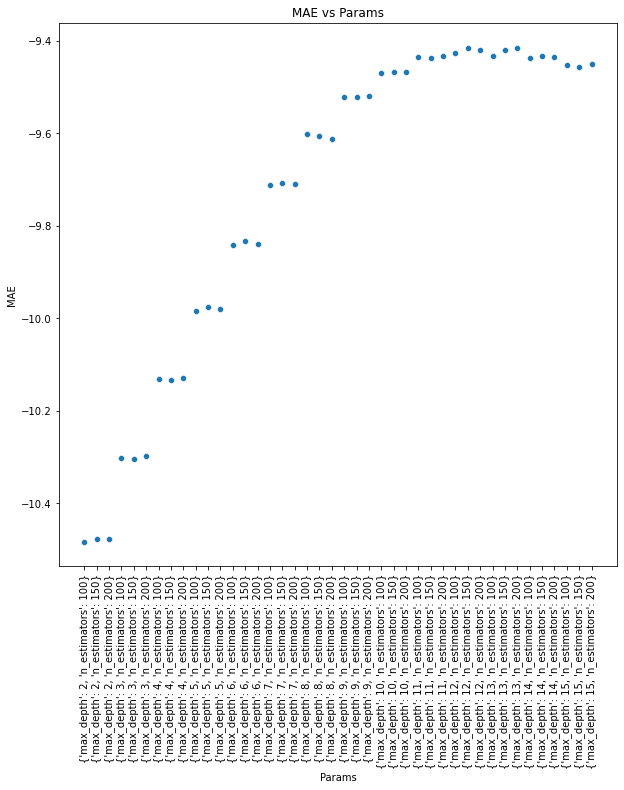

In [17]:
# Mostrar resultados
plt.figure(figsize=(10,10))
sns.scatterplot(x=resultados_rf.params.astype('string'), y=resultados_rf.mean_test_score)
plt.title('MAE vs Params')
plt.ylabel('MAE')
plt.xlabel('Params');
plt. xticks(rotation=90);

errors_mean, errors_std
0.0, 12.62


<Figure size 720x720 with 0 Axes>

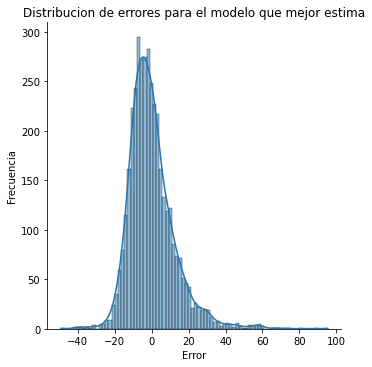

In [18]:
# Mostrar errores

errors = (y_holdout - grid.best_estimator_.predict(X_holdout))
print('errors_mean, errors_std')
mu = np.round(np.mean(errors),2)
sigma = np.round(np.std(errors),2)
print(f'{mu}, {sigma}')
plt.figure(figsize=(10,10))
sns.displot(errors, kde=True)
plt.title('Distribucion de errores para el modelo que mejor estima')
plt.ylabel('Frecuencia')
plt.xlabel('Error');

# 2) Decision Tree Regressor

In [19]:
# import the Model
# Done at the start


# Instantiate the empty model
model = DecisionTreeRegressor()

# import from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

#import scororing function maker and scoring metrics
from sklearn.metrics import make_scorer, mean_absolute_error

# Define params as dictionary
params = {
            'criterion' : ['mae'],
            'max_depth': [ 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
            'max_features' : ["auto"]
            }

# Define scoring func
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Define cv
cv = 3

# Define verbose (0,1,2,3)
verbose = 3


# Instantiate grid  model
grid = GridSearchCV(model, params, scoring=scoring, cv=cv, verbose=verbose) #for example...


# Compute and save
resultados_dt, MAE_dt, RMSE_dt = tune(grid, X, y)


Fitting 3 folds for each of 11 candidates, totalling 33 fits
[CV 1/3] END criterion=mae, max_depth=2, max_features=auto;, score=-10.282 total time=  30.9s
[CV 2/3] END criterion=mae, max_depth=2, max_features=auto;, score=-10.135 total time=  34.1s
[CV 3/3] END criterion=mae, max_depth=2, max_features=auto;, score=-10.310 total time=  33.2s
[CV 1/3] END criterion=mae, max_depth=3, max_features=auto;, score=-10.164 total time=  35.7s
[CV 2/3] END criterion=mae, max_depth=3, max_features=auto;, score=-9.954 total time=  41.3s
[CV 3/3] END criterion=mae, max_depth=3, max_features=auto;, score=-10.121 total time=  41.4s
[CV 1/3] END criterion=mae, max_depth=4, max_features=auto;, score=-10.045 total time=  40.5s
[CV 2/3] END criterion=mae, max_depth=4, max_features=auto;, score=-9.853 total time=  45.5s
[CV 3/3] END criterion=mae, max_depth=4, max_features=auto;, score=-9.970 total time=  46.0s
[CV 1/3] END criterion=mae, max_depth=5, max_features=auto;, score=-9.946 total time=  43.0s
[CV

In [20]:
#resultados_dt

In [48]:
resultados_dt.to_csv('resultados_dt.csv')

In [21]:
grid.best_estimator_.get_params

<bound method BaseEstimator.get_params of DecisionTreeRegressor(criterion='mae', max_depth=7, max_features='auto')>

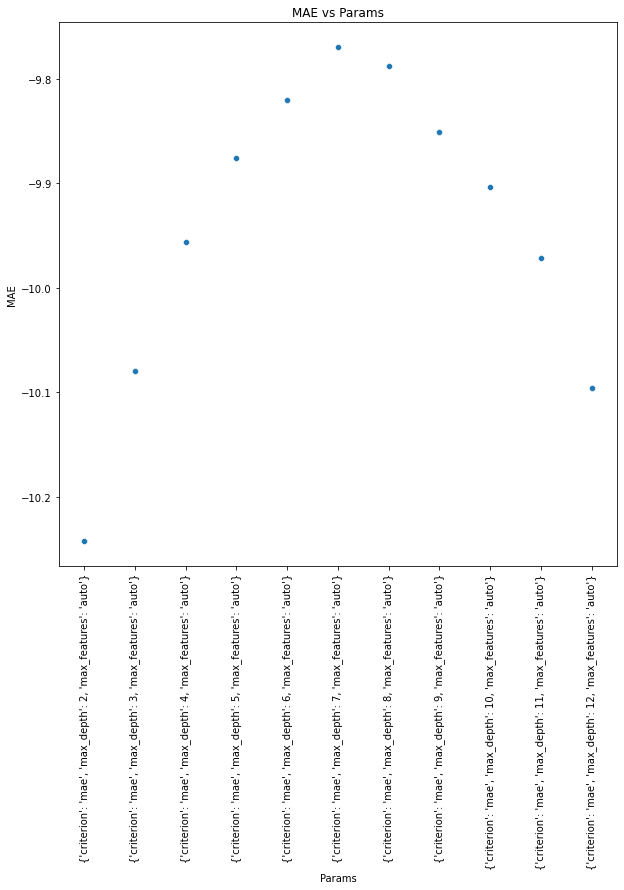

In [22]:
# Mostrar resultados
plt.figure(figsize=(10,10))
sns.scatterplot(x=resultados_dt.params.astype('string'), y=resultados_dt.mean_test_score)
plt.title('MAE vs Params')
plt.ylabel('MAE')
plt.xlabel('Params');
plt. xticks(rotation=90);

errors_mean, errors_std
2.74, 13.38


<Figure size 720x720 with 0 Axes>

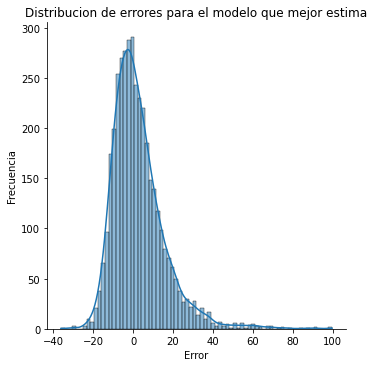

In [23]:
# Mostrar errores

errors = (y_holdout - grid.best_estimator_.predict(X_holdout))
print('errors_mean, errors_std')
mu = np.round(np.mean(errors),2)
sigma = np.round(np.std(errors),2)
print(f'{mu}, {sigma}')
plt.figure(figsize=(10,10))
sns.displot(errors, kde=True)
plt.title('Distribucion de errores para el modelo que mejor estima')
plt.ylabel('Frecuencia')
plt.xlabel('Error');

# 3) Ada Boost Tree

In [24]:
# import the Model
# Done at the start


# Instantiate the empty model
model = AdaBoostRegressor()

# import from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

#import scororing function maker and scoring metrics
from sklearn.metrics import make_scorer, mean_absolute_error

# Define params as dictionary
params = {
            'n_estimators': [50,100],
            'learning_rate': [0.9, 0.95, 1.0, 1.05, 1.1],
            'loss' : ['linear']
                }

# Define scoring func
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Define cv
cv = 3

# Define verbose (0,1,2,3)
verbose = 3


# Instantiate grid  model
grid = GridSearchCV(model, params, scoring=scoring, cv=cv, verbose=verbose) #for example...


# Compute and save
resultados_ab, MAE_ab, RMSE_ab = tune(grid, X, y)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END learning_rate=0.9, loss=linear, n_estimators=50;, score=-18.427 total time=   1.5s
[CV 2/3] END learning_rate=0.9, loss=linear, n_estimators=50;, score=-13.910 total time=   1.0s
[CV 3/3] END learning_rate=0.9, loss=linear, n_estimators=50;, score=-12.011 total time=   1.1s
[CV 1/3] END learning_rate=0.9, loss=linear, n_estimators=100;, score=-14.056 total time=   1.0s
[CV 2/3] END learning_rate=0.9, loss=linear, n_estimators=100;, score=-12.538 total time=   1.1s
[CV 3/3] END learning_rate=0.9, loss=linear, n_estimators=100;, score=-13.462 total time=   0.9s
[CV 1/3] END learning_rate=0.95, loss=linear, n_estimators=50;, score=-15.718 total time=   1.3s
[CV 2/3] END learning_rate=0.95, loss=linear, n_estimators=50;, score=-13.435 total time=   0.8s
[CV 3/3] END learning_rate=0.95, loss=linear, n_estimators=50;, score=-14.015 total time=   0.9s
[CV 1/3] END learning_rate=0.95, loss=linear, n_estimators=100;, scor

In [44]:
resultados_ab

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.240113,0.231299,0.057738,0.015362,0.9,linear,50,"{'learning_rate': 0.9, 'loss': 'linear', 'n_es...",-18.426857,-13.909660,-12.011072,-14.782529,2.690973,8
1,1.069356,0.079417,0.041672,0.007358,0.9,linear,100,"{'learning_rate': 0.9, 'loss': 'linear', 'n_es...",-14.056106,-12.537845,-13.462148,-13.352033,0.624699,1
2,1.053053,0.205097,0.046881,0.012750,0.95,linear,50,"{'learning_rate': 0.95, 'loss': 'linear', 'n_e...",-15.717799,-13.435060,-14.015136,-14.389332,0.968759,5
3,0.928056,0.172957,0.036458,0.007365,0.95,linear,100,"{'learning_rate': 0.95, 'loss': 'linear', 'n_e...",-15.646211,-12.794623,-12.275722,-13.572186,1.481779,3
4,1.011827,0.077669,0.041672,0.007358,1.0,linear,50,"{'learning_rate': 1.0, 'loss': 'linear', 'n_es...",-14.417004,-15.160166,-14.265323,-14.614164,0.391016,6
5,1.240914,0.167578,0.052084,0.014719,1.0,linear,100,"{'learning_rate': 1.0, 'loss': 'linear', 'n_es...",-16.905252,-14.409583,-14.997611,-15.437482,1.065271,9
6,1.200802,0.282647,0.052079,0.019491,1.05,linear,50,"{'learning_rate': 1.05, 'loss': 'linear', 'n_e...",-17.898451,-13.502765,-12.562855,-14.654690,2.325560,7
7,0.867769,0.100323,0.036459,0.007369,1.05,linear,100,"{'learning_rate': 1.05, 'loss': 'linear', 'n_e...",-14.585278,-12.960365,-12.655328,-13.400324,0.847093,2
8,1.095441,0.320664,0.052091,0.019471,1.1,linear,50,"{'learning_rate': 1.1, 'loss': 'linear', 'n_es...",-18.860446,-14.831645,-12.860097,-15.517396,2.497163,10
9,0.845219,0.051393,0.036459,0.007367,1.1,linear,100,"{'learning_rate': 1.1, 'loss': 'linear', 'n_es...",-14.883844,-12.971652,-13.376631,-13.744042,0.822745,4


In [49]:
resultados_ab.to_csv('resultados_ab.csv')

In [26]:
grid.best_estimator_.get_params

<bound method BaseEstimator.get_params of AdaBoostRegressor(learning_rate=0.9, n_estimators=100)>

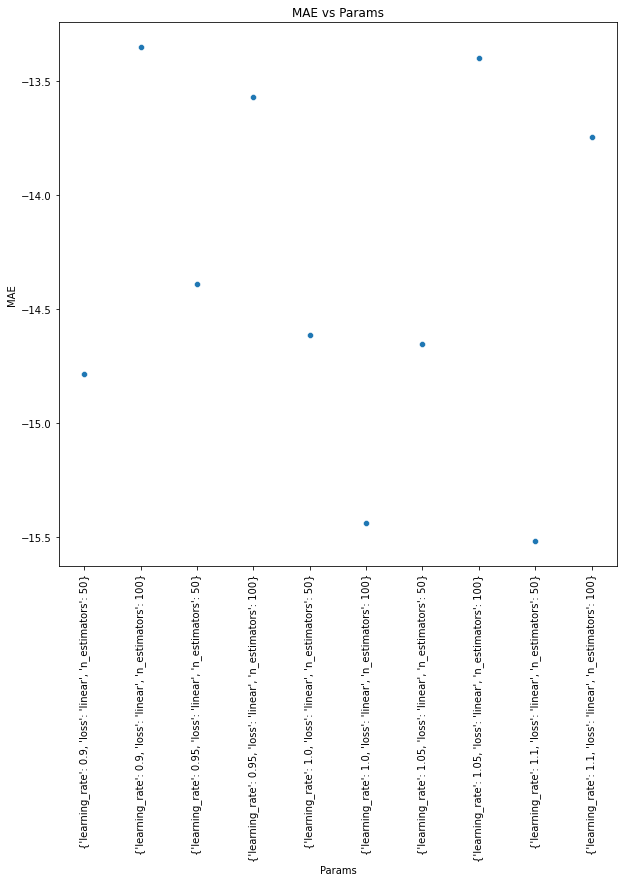

In [27]:
# Mostrar resultados
plt.figure(figsize=(10,10))
sns.scatterplot(x=resultados_ab.params.astype('string'), y=resultados_ab.mean_test_score)
plt.title('MAE vs Params')
plt.ylabel('MAE')
plt.xlabel('Params');
plt. xticks(rotation=90);

errors_mean, errors_std
-8.16, 13.66


<Figure size 720x720 with 0 Axes>

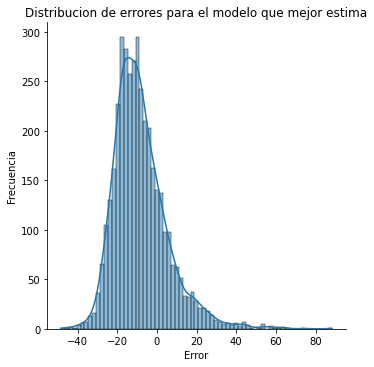

In [28]:
# Mostrar errores

errors = (y_holdout - grid.best_estimator_.predict(X_holdout))
print('errors_mean, errors_std')
mu = np.round(np.mean(errors),2)
sigma = np.round(np.std(errors),2)
print(f'{mu}, {sigma}')
plt.figure(figsize=(10,10))
sns.displot(errors, kde=True)
plt.title('Distribucion de errores para el modelo que mejor estima')
plt.ylabel('Frecuencia')
plt.xlabel('Error');

# 4) Gradient Boost Regressor

In [29]:
# import the Model
# Done at the start


# Instantiate the empty model
model = GradientBoostingRegressor()

# import from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

#import scororing function maker and scoring metrics
from sklearn.metrics import make_scorer, mean_absolute_error

# Define params as dictionary
params = {
            'max_depth':[3,4,5,6,7,8,9,12],
            'learning_rate': [0.08, 0.085, 0.09, 0.095, 0.10, 0.105],
            'loss' : ['huber'],
            'n_estimators': [100]
}

# Define scoring func
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Define cv
cv = 3

# Define verbose (0,1,2,3)
verbose = 3


# Instantiate grid  model
grid = GridSearchCV(model, params, scoring=scoring, cv=cv, verbose=verbose) #for example...


# Compute and save
resultados_gb, MAE_gb, RMSE_gb = tune(grid, X, y)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END learning_rate=0.08, loss=huber, max_depth=3, n_estimators=100;, score=-9.374 total time=   5.7s
[CV 2/3] END learning_rate=0.08, loss=huber, max_depth=3, n_estimators=100;, score=-9.234 total time=   5.7s
[CV 3/3] END learning_rate=0.08, loss=huber, max_depth=3, n_estimators=100;, score=-9.390 total time=   5.7s
[CV 1/3] END learning_rate=0.08, loss=huber, max_depth=4, n_estimators=100;, score=-9.219 total time=   7.4s
[CV 2/3] END learning_rate=0.08, loss=huber, max_depth=4, n_estimators=100;, score=-9.096 total time=   7.4s
[CV 3/3] END learning_rate=0.08, loss=huber, max_depth=4, n_estimators=100;, score=-9.257 total time=   7.5s
[CV 1/3] END learning_rate=0.08, loss=huber, max_depth=5, n_estimators=100;, score=-9.141 total time=   9.5s
[CV 2/3] END learning_rate=0.08, loss=huber, max_depth=5, n_estimators=100;, score=-9.019 total time=   9.5s
[CV 3/3] END learning_rate=0.08, loss=huber, max_depth=5, n_estima

[CV 1/3] END learning_rate=0.095, loss=huber, max_depth=4, n_estimators=100;, score=-9.203 total time=   7.4s
[CV 2/3] END learning_rate=0.095, loss=huber, max_depth=4, n_estimators=100;, score=-9.064 total time=   7.4s
[CV 3/3] END learning_rate=0.095, loss=huber, max_depth=4, n_estimators=100;, score=-9.226 total time=   7.5s
[CV 1/3] END learning_rate=0.095, loss=huber, max_depth=5, n_estimators=100;, score=-9.142 total time=   9.4s
[CV 2/3] END learning_rate=0.095, loss=huber, max_depth=5, n_estimators=100;, score=-8.999 total time=   9.5s
[CV 3/3] END learning_rate=0.095, loss=huber, max_depth=5, n_estimators=100;, score=-9.174 total time=   9.5s
[CV 1/3] END learning_rate=0.095, loss=huber, max_depth=6, n_estimators=100;, score=-9.117 total time=  12.0s
[CV 2/3] END learning_rate=0.095, loss=huber, max_depth=6, n_estimators=100;, score=-8.987 total time=  11.9s
[CV 3/3] END learning_rate=0.095, loss=huber, max_depth=6, n_estimators=100;, score=-9.157 total time=  11.9s
[CV 1/3] E

In [42]:
resultados_gb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.748301,0.019383,0.041665,7.366370e-03,0.08,huber,3,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-9.374446,-9.234399,-9.390024,-9.332957,0.069980,42
1,7.499751,0.012582,0.046872,6.743496e-07,0.08,huber,4,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-9.218723,-9.096421,-9.256743,-9.190629,0.068399,35
2,9.537745,0.021701,0.046870,4.899036e-07,0.08,huber,5,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-9.141139,-9.019451,-9.198200,-9.119597,0.074547,23
3,12.077693,0.067438,0.067700,7.359233e-03,0.08,huber,6,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-9.143016,-9.002872,-9.146704,-9.097531,0.066950,15
4,15.370302,0.146570,0.078117,7.816672e-06,0.08,huber,7,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-9.092512,-8.995658,-9.128721,-9.072297,0.056172,1
5,19.837042,0.130897,0.088364,7.242951e-03,0.08,huber,8,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-9.136927,-8.982382,-9.114553,-9.077954,0.068194,4
6,25.788031,0.193620,0.104338,7.491321e-03,0.08,huber,9,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-9.175624,-9.048210,-9.163405,-9.129080,0.057401,25
7,60.023180,0.991817,0.140626,5.619580e-07,0.08,huber,12,100,"{'learning_rate': 0.08, 'loss': 'huber', 'max_...",-9.443620,-9.376386,-9.399428,-9.406478,0.027897,44
8,5.729334,0.022679,0.041664,7.367663e-03,0.085,huber,3,100,"{'learning_rate': 0.085, 'loss': 'huber', 'max...",-9.359850,-9.217306,-9.376431,-9.317862,0.071425,41
9,7.471245,0.004643,0.041663,7.367494e-03,0.085,huber,4,100,"{'learning_rate': 0.085, 'loss': 'huber', 'max...",-9.237017,-9.094015,-9.255881,-9.195638,0.072270,36


In [50]:
resultados_gb.to_csv('resultados_gb.csv')

In [31]:
grid.best_estimator_.get_params

<bound method BaseEstimator.get_params of GradientBoostingRegressor(learning_rate=0.08, loss='huber', max_depth=7)>

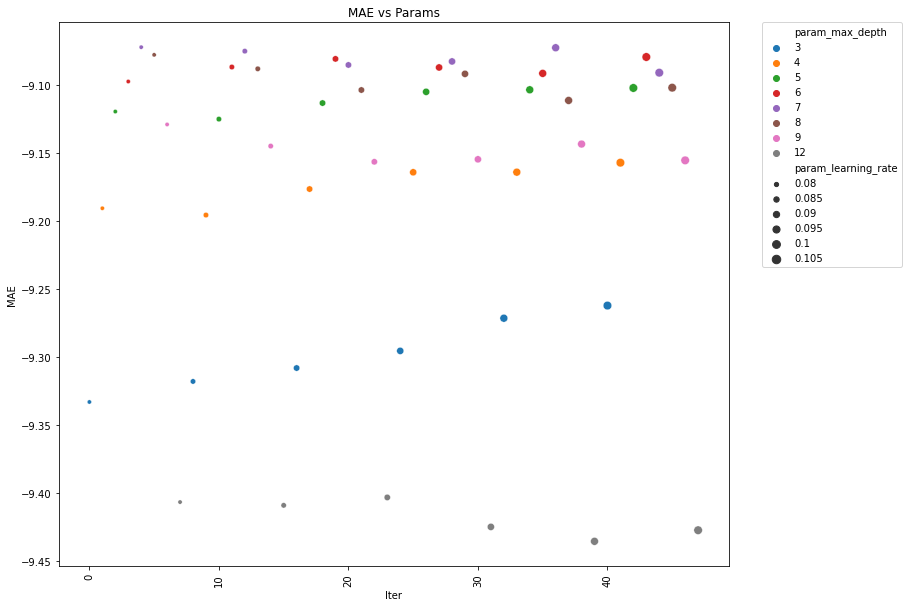

In [71]:
# Mostrar resultados
plt.figure(figsize=(12,10))
sns.scatterplot(x=resultados_gb.index, y=resultados_gb.mean_test_score, hue=resultados_gb.param_max_depth, size=resultados_gb.param_learning_rate, palette='tab10')
plt.title('MAE vs Params')
plt.ylabel('MAE')
plt.xlabel('Iter');
plt. xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

errors_mean, errors_std
1.21, 12.32


<Figure size 720x720 with 0 Axes>

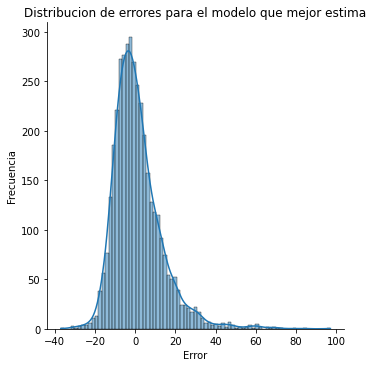

In [33]:
# Mostrar errores

errors = (y_holdout - grid.best_estimator_.predict(X_holdout))
print('errors_mean, errors_std')
mu = np.round(np.mean(errors),2)
sigma = np.round(np.std(errors),2)
print(f'{mu}, {sigma}')
plt.figure(figsize=(10,10))
sns.displot(errors, kde=True)
plt.title('Distribucion de errores para el modelo que mejor estima')
plt.ylabel('Frecuencia')
plt.xlabel('Error');

# 5) Support Vector Machine Regressor

In [34]:
# import the Model
# Done at the start


# Instantiate the empty model
model = SVR()

# import from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV

#import scororing function maker and scoring metrics
from sklearn.metrics import make_scorer, mean_absolute_error


# Define params as dictionary

params = {
            'C': [ 0.1, 1, 10, 100],
            'epsilon': [0.001, 0.01, 0.1]
                }

# Define scoring func
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Define cv
cv = 3

# Define verbose (0,1,2,3)
verbose = 3


# Instantiate grid  model
grid = GridSearchCV(model, params, scoring=scoring, cv=cv, verbose=verbose) #for example...

# Scale data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
X_sc_holdout = scaler.transform(X_holdout)

# Compute and save
resultados_svr, MAE_svr, RMSE_svr = tune_sc(grid, X_sc, y)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END .............C=0.1, epsilon=0.001;, score=-9.790 total time= 1.7min
[CV 2/3] END .............C=0.1, epsilon=0.001;, score=-9.652 total time= 1.7min
[CV 3/3] END .............C=0.1, epsilon=0.001;, score=-9.872 total time= 1.7min
[CV 1/3] END ..............C=0.1, epsilon=0.01;, score=-9.790 total time= 1.7min
[CV 2/3] END ..............C=0.1, epsilon=0.01;, score=-9.652 total time= 1.7min
[CV 3/3] END ..............C=0.1, epsilon=0.01;, score=-9.873 total time= 1.7min
[CV 1/3] END ...............C=0.1, epsilon=0.1;, score=-9.791 total time= 1.7min
[CV 2/3] END ...............C=0.1, epsilon=0.1;, score=-9.652 total time= 1.7min
[CV 3/3] END ...............C=0.1, epsilon=0.1;, score=-9.872 total time= 1.7min
[CV 1/3] END ...............C=1, epsilon=0.001;, score=-9.544 total time= 1.7min
[CV 2/3] END ...............C=1, epsilon=0.001;, score=-9.391 total time= 1.7min
[CV 3/3] END ...............C=1, epsilon=0.001;,

In [45]:
resultados_svr

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,61.619048,0.072973,43.193317,0.041185,0.1,0.001,"{'C': 0.1, 'epsilon': 0.001}",-9.789994,-9.652231,-9.872422,-9.771549,0.090834,10
1,61.558004,0.180172,43.138702,0.096280,0.1,0.01,"{'C': 0.1, 'epsilon': 0.01}",-9.789920,-9.652375,-9.872651,-9.771649,0.090851,12
2,61.340836,0.114786,42.797002,0.027784,0.1,0.1,"{'C': 0.1, 'epsilon': 0.1}",-9.790927,-9.652082,-9.871821,-9.771610,0.090742,11
3,61.103237,0.116847,43.155584,0.040181,1,0.001,"{'C': 1, 'epsilon': 0.001}",-9.544028,-9.391031,-9.622891,-9.519317,0.096256,9
4,60.884586,0.109472,43.063339,0.050727,1,0.01,"{'C': 1, 'epsilon': 0.01}",-9.543858,-9.391099,-9.622888,-9.519282,0.096210,8
5,60.764091,0.080781,42.942454,0.088759,1,0.1,"{'C': 1, 'epsilon': 0.1}",-9.543750,-9.391051,-9.622949,-9.519250,0.096244,7
6,62.485380,0.333586,43.199808,0.113781,10,0.001,"{'C': 10, 'epsilon': 0.001}",-9.482106,-9.335891,-9.544360,-9.454119,0.087377,3
7,62.153413,0.298825,43.122479,0.060973,10,0.01,"{'C': 10, 'epsilon': 0.01}",-9.482125,-9.335718,-9.544370,-9.454071,0.087461,2
8,62.311155,0.063219,42.836757,0.115521,10,0.1,"{'C': 10, 'epsilon': 0.1}",-9.481712,-9.333248,-9.544605,-9.453188,0.088612,1
9,79.651772,0.072545,43.144053,0.056470,100,0.001,"{'C': 100, 'epsilon': 0.001}",-9.506844,-9.363250,-9.563996,-9.478030,0.084449,6


In [51]:
resultados_svr.to_csv('resultados_svr.csv')

In [36]:
grid.best_estimator_.get_params

<bound method BaseEstimator.get_params of SVR(C=10)>

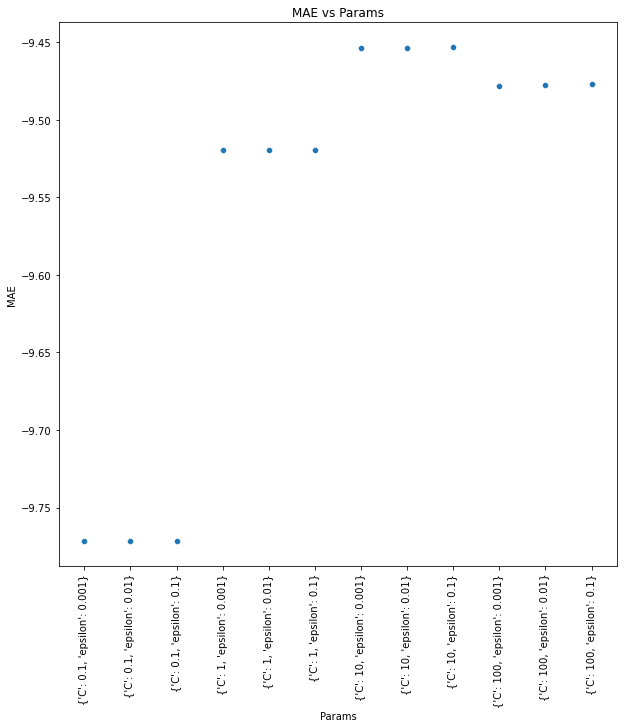

In [37]:
# Mostrar resultados

plt.figure(figsize=(10,10))
sns.scatterplot(x=resultados_svr.params.astype('string'), y=resultados_svr.mean_test_score)
plt.title('MAE vs Params')
plt.ylabel('MAE')
plt.xlabel('Params');
plt. xticks(rotation=90);

errors_mean, errors_std
2.58, 12.99


<Figure size 720x720 with 0 Axes>

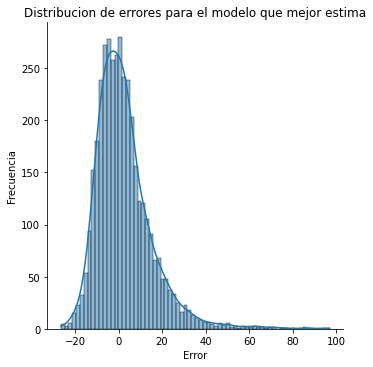

In [38]:
# Mostrar errores

errors = (y_holdout - grid.best_estimator_.predict(X_sc_holdout))
print('errors_mean, errors_std')
mu = np.round(np.mean(errors),2)
sigma = np.round(np.std(errors),2)
print(f'{mu}, {sigma}')
plt.figure(figsize=(10,10))
sns.displot(errors, kde=True)
plt.title('Distribucion de errores para el modelo que mejor estima')
plt.ylabel('Frecuencia')
plt.xlabel('Error');

# 6) Results

In [39]:
df = pd.DataFrame({
    "Algoritmo": ['Modelo actual','Decision Tree','Random Forest','Ada Boost','Gradient Boost','SVM','ANN'],
    "MAE": [MAE_py, MAE_dt, MAE_rf, MAE_ab, MAE_gb, MAE_svr, 9.4],
    "RMSE": [RMSE_py, RMSE_dt, RMSE_rf, RMSE_ab, RMSE_gb, RMSE_svr, 13.44]
})

In [40]:
df.sort_values(by=['MAE','RMSE'], inplace=True)

In [52]:
df.to_csv('resultados.csv')

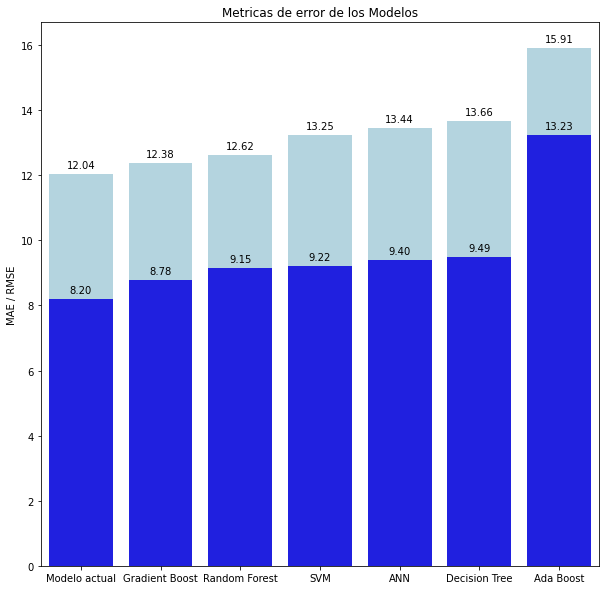

In [41]:
plt.figure(figsize=(10,10))

s1 = sns.barplot(x = 'Algoritmo', y = 'RMSE', data = df, color = 'lightblue')

s2 = sns.barplot(x = 'Algoritmo', y = 'MAE', data = df, color = 'blue')

for p in s1.patches:
    s1.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
plt.title('Metricas de error de los Modelos')
plt.ylabel('MAE / RMSE')
plt.xlabel('');